<a href="https://colab.research.google.com/github/linainsaf/Dual-Attention-Guided-Gaze-Target-Detection-in-the-Wild/blob/main/Projet_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Depth Estimation Network

In [ ]:
pip install timm

     |████████████████████████████████| 376 kB 8.1 MB/s 


In [ ]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

### load model :

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt" to /root/.cache/torch/hub/checkpoints/dpt_large-midas-2f21e586.pt


  0%|          | 0.00/1.28G [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
            (dro

### load image transformations for large model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


### load images

In [ ]:
filename="test.jpg"
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

### Make predicions

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


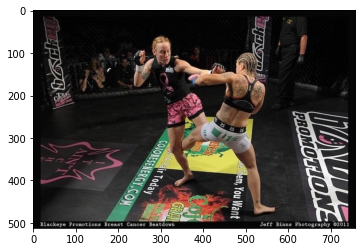

In [ ]:
plt.imshow(img)

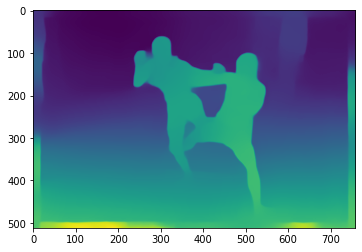

In [ ]:
plt.imshow(output)


In [ ]:
import numpy as np
import cv2
def eye_head_extractor(img):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
  face,eye=[],[]
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 1)

  for (x,y,w,h) in faces:
      face.append(img[y:y+h,x:x+w])
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = img[y:y+h, x:x+w]
      eyes = eye_cascade.detectMultiScale(roi_gray,1.3,1)
      for (ex,ey,ew,eh) in eyes:
          eye.append(roi_color[ey:ey+eh,ex:ex+ew])          
  return face,eye


In [ ]:
face,eye=eye_head_extractor(img)

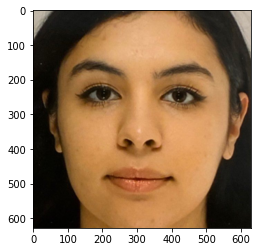

In [ ]:
plt.imshow(face[0])


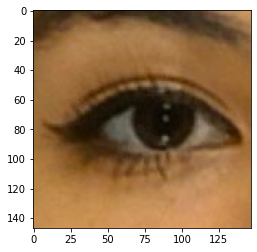

In [ ]:
plt.imshow(eye[0])


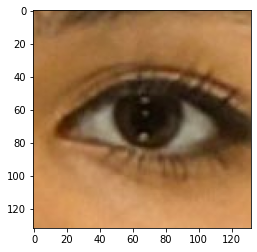

In [ ]:
plt.imshow(eye[1])


In [ ]:
import sys
import torch
import torchvision.transforms as transforms
import imageio
import cv2
import random
from PIL import Image
import math
import torch
import torchvision.transforms as transforms
import sys
image_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [ ]:
! git clone https://github.com/erkil1452/gaze360

In [ ]:
! wget http://gaze360.csail.mit.edu/files/gaze360_model.pth.tar

--2021-11-07 17:47:42--  http://gaze360.csail.mit.edu/files/gaze360_model.pth.tar
Resolving gaze360.csail.mit.edu (gaze360.csail.mit.edu)... 128.30.2.44
Connecting to gaze360.csail.mit.edu (gaze360.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58370849 (56M) [application/x-tar]
Saving to: ‘gaze360_model.pth.tar’

gaze360_model.pth.t 100%[===================>]  55.67M  12.9MB/s    in 4.8s    

2021-11-07 17:47:48 (11.6 MB/s) - ‘gaze360_model.pth.tar’ saved [58370849/58370849]



In [ ]:
sys.path.append('/content/gaze360/code/')
import GazeLSTM
model = GazeLSTM()
model = torch.nn.DataParallel(model).cuda()
model.cuda()
checkpoint = torch.load('/content/gaze360_model.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()

ModuleNotFoundError: ignored